In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-ingredients-dataset/train.json
/kaggle/input/recipe-ingredients-dataset/test.json


# Ingredients Network analysis

In this Project we will try to understand basic food combinations.

Following features will be identified:

---

* Base ingredients
* Ingredient Combinations
* Ingredient Groups

## Prepare Data

### Load Dataset

The first step is of course to load the dataset. Since our data is saved in a .json format. We can either write an parser or directly use pandas `read_json()` method.

In [2]:
data = pd.read_json("/kaggle/input/recipe-ingredients-dataset/train.json")
data.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


## 

### Identify all ingredients used

Our ingredients column consists of several list representing the ingredients used in each recipe.
Here, we can use different approaches to unpack our list and get the unique values, but the easiest by far is just to use the `explode()` method and then call the `unique()` method. 

In [3]:
ingredients = data.ingredients.explode().unique()
ingredients

array(['romaine lettuce', 'black olives', 'grape tomatoes', ...,
       'lop chong', 'tomato garlic pasta sauce',
       'crushed cheese crackers'], dtype=object)

### Importance of Ingredients

The importance of our ingredients can be identified by the numbers of uses in each recipe. So fo this we will fill a dictionary with the count values of each ingredient in the whole dataset.

In [4]:
recipeIngredients = data.ingredients.explode()
recipeIngredients
countIngredients = recipeIngredients.value_counts().reset_index()
# dfCountIngredients = countIngredients.to_frame()
countIngredients = countIngredients.rename(columns = {"index":"Ingredient", "ingredients":"weight"})

In [5]:
countIngredients 

,Ingredient,weight
0,salt,18049
1,olive oil,7972
2,onions,7972
3,water,7457
4,garlic,7380
...,...,...
6709,sauerkraut juice,1
6710,no-calorie sweetener,1
6711,Bob Evans Italian Sausage,1
6712,extra firm silken tofu,1


### Relationships

With our ingredients and weight dataframe we can now start to extract the relationships. Which is essetially the number of times each ingredient was mentioned in a specific recipe.

In [6]:
#for ingre in countIngredients.Ingredient[:1]:
    #ingreRela[ingre] = [data.ingredients.apply(lambda x: ingre in x)]
    #mask = data.ingredients.apply(lambda x: ingre in x)
                       
#len(data.ingredients[mask].explode().unique())
def getRelationships(data, countIngredients):
    masks = []
    ingredientsRelations = []
    for ingre in countIngredients.Ingredient:
        masks.append(data.ingredients.apply(lambda x: ingre in x))
    for mask in masks:
        ingredientsRelations.append(data.ingredients[mask].explode().unique())
    countIngredients ["Relationships"] = ingredientsRelations
    return countIngredients
    
dfRelationship = getRelationships(data,countIngredients)

---
***To be honest we should have extracted our relationships but looking at the runtime of that code its kinda clear that I used the most ineffcient way there is. If anybody has a better solution pls let me know :)***

---

### Relationship Graph
At this point we are ready to build our networkx graph. To visualize the connection between all the ingredients. We have our Nodes given as our ingredients and our edges will be our extracted Relationships. The weight can be used as sizing factor for our Nodes.

In [7]:
# dfRelationship = data.Relationships.explode()
dfRelationship['count_relationships'] = dfRelationship['Relationships'].str.len()

dfRelationship

,Ingredient,weight,Relationships,count_relationships
0,salt,18049,"[plain flour, ground pepper, salt, tomatoes, g...",4880
1,olive oil,7972,"[olive oil, salt, medium shrimp, pepper, garli...",3429
2,onions,7972,"[black pepper, shallots, cornflour, cayenne pe...",3662
3,water,7457,"[water, vegetable oil, wheat, salt, black pepp...",3893
4,garlic,7380,"[romaine lettuce, black olives, grape tomatoes...",3544
...,...,...,...,...
6709,sauerkraut juice,1,"[parsnips, ground black pepper, vegetable oil,...",20
6710,no-calorie sweetener,1,"[water, lemon slices, tea bags, no-calorie swe...",5
6711,Bob Evans Italian Sausage,1,"[red pepper, Bob Evans Italian Sausage, provol...",7
6712,extra firm silken tofu,1,"[red chili peppers, radishes, ginger, snow pea...",17


In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# well I lied after looking in the nx docs we first have to unpack our list of relationships

dfRelationship.explode("Relationships")

## that will make our dataset kinda big so I will remove the salt column (I would prefere removing all spices)
    ## but for that I would need a dataset to crossmatch
#edgedf = dfRelationship[(dfRelationship.weight < 100)&(dfRelationship.weight > 50)].explode("Relationships")
#edgedf = dfRelationship[:20].explode("Relationships")
edgedf = dfRelationship[dfRelationship.Ingredient == "butter"].explode("Relationships")
edgedf = edgedf[edgedf.Ingredient != edgedf.Relationships] ## remove edges from and to same node (salt --> salt)

In [9]:
edgedf

,Ingredient,weight,Relationships,count_relationships
7,butter,4848,eggs,2949
7,butter,4848,pepper,2949
7,butter,4848,salt,2949
7,butter,4848,mayonaise,2949
7,butter,4848,cooking oil,2949
...,...,...,...,...
7,butter,4848,smoked turkey,2949
7,butter,4848,golden mushroom soup,2949
7,butter,4848,citrus fruit,2949
7,butter,4848,sourdough starter,2949


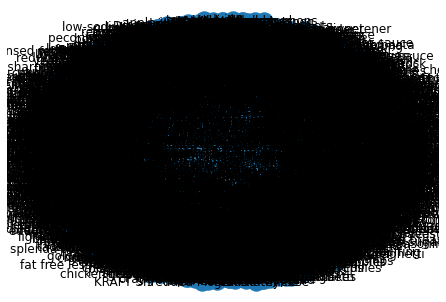

In [10]:
G = nx.from_pandas_edgelist(edgedf,"Ingredient","Relationships")
nx.draw(G,with_labels=True)
plt.show()

In [11]:
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.8/592.8 kB 820.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pyvis: filename=pyvis-0.3.0-py3-none-any.whl size=600250 sha256=8c87d760877cd1113a7bd2bff9b280cf4623699862952bccd034d21560950cc8
  Stored in directory: /root/.cache/pip/wheels/57/74/32/e404e0d76fbb2dc4e3791b821cfae6a69c1a6677ded99dc8b7
Successfully built pyvis


In [12]:
from pyvis.network import Network

net = Network(notebook=True)
net.from_nx(G)
net.show("butter.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## Conclusion

---

 As we can see here we are able to create a graph but considering the current runtime an improvement of the graph and working with a larger slice of our data is not feasible at that point. Another thing which would be interesting to look at is to introduce group theory, which would help to identify directions of meals and might be perfect for a Food recommendation system

---